In [79]:
import numpy as np
import numpy.linalg as la
import scipy.linalg as spla
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.kernel_approximation import RBFSampler

from sklearn.linear_model import SGDRegressor
# https://stackoverflow.com/questions/68607375/last-step-of-pipeline-should-implement-fit-or-be-the-string-passthrough
from sklearn.pipeline import Pipeline # make_pipeline
from sklearn.preprocessing import StandardScaler

# https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
# https://stackoverflow.com/questions/62336142/modulenotfounderror-no-module-named-sklearn-utils-testing
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

## (Non-)Linear function approximation
Our goal is to test how to do function approximation. 
We consider the following functions, all with the domain $X \equiv \mathbb{R}^{n}$ with $n=1$:

Linear:
$$
f_1 \mapsto x.
$$

Quadratic
$$
f_2 \mapsto x^2.
$$

Simple periodic
$$
f_3 \mapsto \sin(x)
$$

Simple step-wise: 
$$
f_4 \mapsto \mathbf{1}[\vert x \vert \leq 5].
$$

Polynomial
$$
f_5 \mapsto \frac{1}{1000}(x-6)(x-4)(x+3)^2(x+4)
$$

In [2]:
n = 1

def f1(x):
    return x

def f2(x):
    return np.square(x)

def f3(x):
    return np.sin(x) 

def f4(x):
    return (np.abs(x) <= 5).astype("int")
    
def f5(x):
    return (x-6)*(x-4)*(x+3)**2*(x+4)/1000

[Text(0.5, 1.0, 'Function values by affine transformation'),
 Text(0.5, 0, '$x$'),
 Text(0, 0.5, '$f(x)$')]

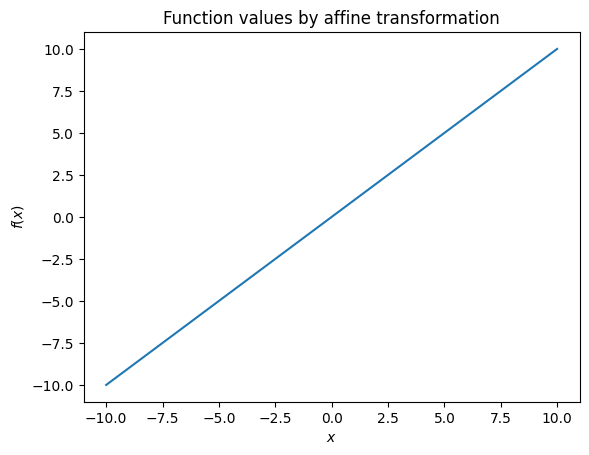

In [3]:
xs = np.linspace(-10, 10, 1000)
ax = plt.subplot()
ax.plot(xs, f1(xs))
ax.set(
    title="Function values by affine transformation", 
    xlabel=r"$x$", 
    ylabel=r"$f(x)$"
)

## Monomial Fitting
First we will fit by polynomials (up to degree $d$)

$$\begin{aligned}
    v_{d\cdot i+j}(x) &= x_i^j, ~~ i=1,\ldots,n; j=1,\ldots,d.
\end{aligned}$$

Then we want to learn a weights vector $\omega \in \mathbb{R}^{d \cdot n}$ such that:
$$
    f_k(x) \approx v(x)^T\omega.
$$

We will evaluate over the domain [-10,10].

In [84]:
# create training points and test points
def get_polynomial_Ab(f, d, data_set):
    A = None
    b = np.zeros(len(data_set), dtype=float)
    for i,data_pt in enumerate(data_set): 
        V = np.vander(data_pt, increasing=True, N=d)
        # V = spla.dft
        v = np.reshape(V, newshape=(-1,))
        if A is None:
            A = np.zeros((len(data_set), len(v)), dtype=float)
        A[i] = v
        b[i] = f(data_pt)
        
    return A,b

def get_Ab(f, n, d, n_train, n_test, get_Ab_obj, seed=0):
    rng = np.random.default_rng(seed)
    train_set = 20*rng.random(size=(n_train, n))-10
    test_set  = 20*rng.random(size=(n_test, n))-10

    A_train, b_train = get_Ab_obj(f, d, train_set)
    A_test, b_test = get_Ab_obj(f, d, test_set)
    
    return (A_train, b_train, A_test, b_test)

Fit the data! Our degrees are chosen by simple tuning.

In [85]:
@ignore_warnings(category=ConvergenceWarning)
def _test(n, ds, n_train, n_test, get_Ab_obj, seed, model):
    """ Runs single trial to get accuracy of function approximation """
    m = len(ds)
    fs = [f"f{i}" for i in range(1,m+1)]

    err_train_arr = np.zeros(m, dtype=float)
    err_test_arr = np.zeros(m, dtype=float)
    
    ct = 0
    for fn,d in zip(fs, ds):
        # TODO: Can we to locals()
        (A_train, b_train, A_test, b_test) = get_Ab(
            globals()[fn], 
            n, 
            d, 
            n_train, 
            n_test, 
            get_Ab_obj, 
            seed
        )
        model.fit(A_train,b_train)
        # omega = model.coef_
        omega = model.named_steps['reg'].coef_
        # TODO: Why is behavior different than least squares?
        # omega = la.lstsq(A_train, b_train)[0]

        y_train = A_train@omega
        y_test = A_test@omega
        err_train = la.norm(b_train-y_train, ord=2)/n_train
        err_test = la.norm(b_test-y_test, ord=2)/n_test
        err_train_arr[ct] = err_train
        err_test_arr[ct] = err_test
        ct += 1
        
    return err_train_arr, err_test_arr

def test(n, ds, n_train, n_test, get_Ab_obj, model, n_seeds=100):
    """ Runs multiple trials to test the accuracy """
    all_err_train = np.zeros((len(ds), n_seeds), dtype=float)
    all_err_test  = np.zeros((len(ds), n_seeds), dtype=float)
    for i, seed in enumerate(range(n_seeds)):
        err_train, err_test = _test(n, ds, n_train, n_test, get_Ab_obj, seed, model)
        all_err_train[:,i] = err_train
        all_err_test[:,i] = err_test

    train_err_means = np.mean(all_err_train, axis=1)
    train_err_stds  = np.std(all_err_train, axis=1)
    test_err_means = np.mean(all_err_test, axis=1)
    test_err_stds  = np.std(all_err_test, axis=1)

    print(f"{'='*12} Presenting statistics below {'='*12}")
    for i in range(len(ds)):
        print(f"f_{i+1} train error {train_err_means[i]:.2e} +/- {train_err_stds[i]:.2e}")
        print(f"f_{i+1} test error {test_err_means[i]:.2e} +/- {test_err_stds[i]:.2e}")
        if i < len(ds)-1:
            print("")
    print(f"{'='*12} Finished statistics summary {'='*12}")

In [115]:
ds = [2,3,3,3,3]
ds = [2,2,4,4,4]
ds = 7 * np.ones(5, dtype=int)
n_train = 40
n_test = 20
model = Pipeline([
    # ("scalar", StandardScaler()),
    ("reg", linear_model.LinearRegression())
])
test(n, ds, n_train, n_test, get_polynomial_Ab, model)

============ Presenting statistics below ============
f_1 train error 5.75e-12 +/- 3.04e-12
f_1 test error 7.91e-12 +/- 4.43e-12

f_2 train error 1.25e-12 +/- 1.42e-12
f_2 test error 1.70e-12 +/- 1.54e-12

f_3 train error 1.03e-01 +/- 1.70e-02
f_3 test error 2.00e-01 +/- 1.50e-01

f_4 train error 1.78e-01 +/- 8.50e-03
f_4 test error 2.52e-01 +/- 2.13e-02

f_5 train error 1.37e-01 +/- 1.87e-12
f_5 test error 1.93e-01 +/- 2.72e-12
============ Finished statistics summary ============


Plot

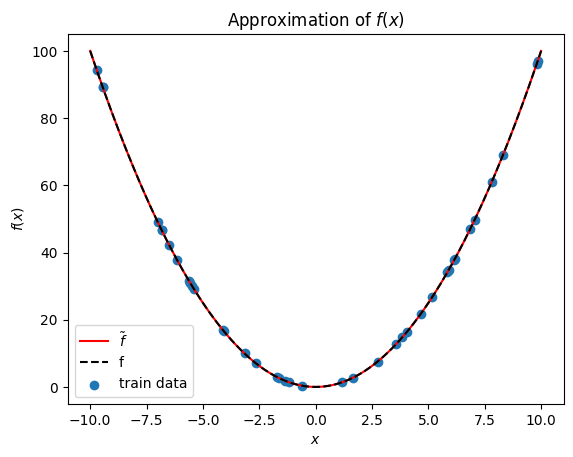

In [119]:
i = 2
f = locals()[f"f{i}"]
d = ds[i-1]
seed = None

# train to get weights
rng = np.random.default_rng(seed)
train_set = 20*rng.random(size=(n_train, n))-10
(A_train, b_train) = get_polynomial_Ab(f, d, train_set)
model.fit(A_train, b_train)
omega = model.named_steps['reg'].coef_

# evaluate the model
xs = np.linspace(-10, 10, 1000)
eval_set = np.diag(xs) @ np.ones((len(xs), n))
(A_eval, b_eval) = get_polynomial_Ab(f, d, eval_set)

# plot
ax = plt.subplot()
ax.plot(xs, A_eval@omega, label=r"$\tilde{f}$", linestyle="solid", color="red")
ax.plot(xs, b_eval, label="f", linestyle="dashed", color="black")
ax.scatter(train_set, f(train_set), label="train data")
ax.set(
    title=r"Approximation of $f(x)$", 
    xlabel=r"$x$", 
    ylabel=r"$f(x)$"
)
ax.legend()

#### Ridge regression
Let's try it again with regularization (i.e., ridge regression). This time, we should get less weird actions around the edges.

In [120]:
ds = 7*np.ones(5, dtype=int)
n_train = 100
n_test = 20
model = Pipeline([
    # ("scalar", StandardScaler()),
    ("reg", linear_model.Ridge(alpha=.1))
])
test(n, ds, n_train, n_test, get_polynomial_Ab, model)

============ Presenting statistics below ============
f_1 train error 8.01e-05 +/- 4.93e-06
f_1 test error 1.96e-04 +/- 7.84e-05

f_2 train error 5.36e-05 +/- 6.98e-06
f_2 test error 1.25e-04 +/- 2.98e-05

f_3 train error 6.48e-02 +/- 4.39e-03
f_3 test error 1.57e-01 +/- 5.02e-02

f_4 train error 1.14e-01 +/- 2.90e-03
f_4 test error 2.55e-01 +/- 1.20e-02

f_5 train error 8.64e-02 +/- 6.70e-06
f_5 test error 1.93e-01 +/- 2.76e-05
============ Finished statistics summary ============


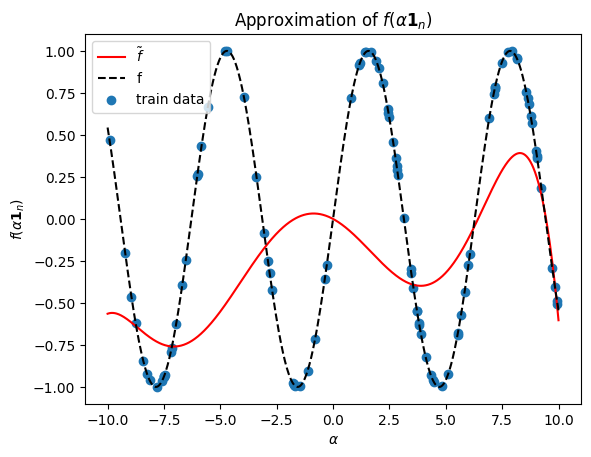

In [122]:
i = 3
f = locals()[f"f{i}"]
d = ds[i-1]
seed = None

# train to get weights
rng = np.random.default_rng(seed)
train_set = 20*rng.random(size=(n_train, n))-10
(A_train, b_train) = get_polynomial_Ab(f, d, train_set)
model.fit(A_train, b_train)
omega = model.named_steps['reg'].coef_

# evaluate the model
xs = np.linspace(-10, 10, 1000)
eval_set = np.diag(xs) @ np.ones((len(xs), n))
(A_eval, b_eval) = get_polynomial_Ab(f, d, eval_set)

# plot
ax = plt.subplot()
ax.plot(xs, A_eval@omega, label=r"$\tilde{f}$", linestyle="solid", color="red")
ax.plot(xs, b_eval, label="f", linestyle="dashed", color="black")

ax.scatter(train_set, f(train_set), label="train data")
ax.set(
    title=r"Approximation of $f(\alpha \mathbf{1}_n)$", 
    xlabel=r"$\alpha$", 
    ylabel=r"$f(\alpha \mathbf{1}_n)$"
)
ax.legend()

## Fourier basis

Recall $x \in \mathbb{R}^n$. Recall that we want to learn a basis $v$ such that
$$
f(x) \approx v(x)^T \omega
$$
for some $\omega \in \mathbb{R}^d$. We define the basis
$$
v_i(x) = \cos(\pi \cdot x^Tc^{(i)}).
$$
where $c^{(i)}_j \in \{0,\ldots,n\}$. Noticing there are $(n+1)^n$ possible $c^{(i)}$ since the vector can only take on discrete values, although we do not need to use all of them. 

In [130]:
# create training points and test points
def get_fourier_Ab(f, d, data_set,seed=0):
    n = data_set.shape[1]
    A = np.zeros((len(data_set), d), dtype=float)
    b = np.zeros(len(data_set), dtype=float)
    rng = np.random.default_rng(seed)
    C = rng.integers(low=0, high=(4*n)+1, size=(d, n))
    for i,data_pt in enumerate(data_set): 
        A[i] = np.cos(np.pi * C@data_pt)
        b[i] = f(data_pt)

    return (A,b)

In [131]:
ds = 10 * np.ones(5, dtype=int)
n_train = 100
n_test = 20
model = Pipeline([
    # ("scalar", StandardScaler()),
    # ("reg", linear_model.LinearRegression())
    ("reg", linear_model.Ridge(alpha=.1))
])
test(n, ds, n_train, n_test, get_fourier_Ab, model)

============ Presenting statistics below ============
f_1 train error 5.63e-01 +/- 2.62e-02
f_1 test error 1.30e+00 +/- 1.36e-01

f_2 train error 4.41e+00 +/- 3.11e-01
f_2 test error 9.97e+00 +/- 1.52e+00

f_3 train error 6.74e-02 +/- 2.64e-03
f_3 test error 1.58e-01 +/- 1.36e-02

f_4 train error 7.00e-02 +/- 3.46e-03
f_4 test error 1.59e-01 +/- 1.89e-02

f_5 train error 1.62e+00 +/- 2.37e-01
f_5 test error 3.56e+00 +/- 1.04e+00
============ Finished statistics summary ============


Here, we need to run ridge regression (i.e., regularize the weights) since the combiniatorial nature of the problem can lead to ill-conditioned problems.

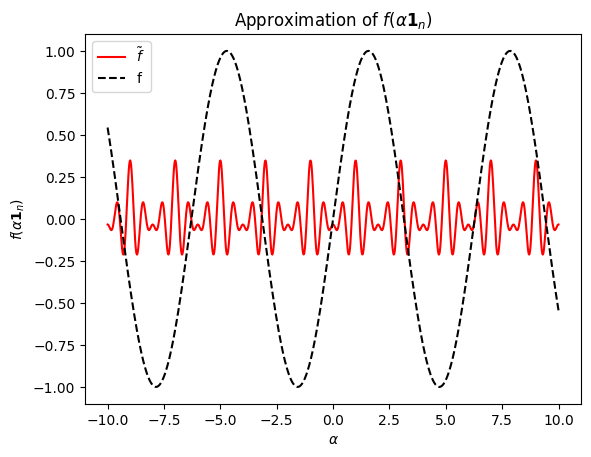

In [134]:
i = 3
f = locals()[f"f{i}"]
d = ds[i-1]
seed = None

# train to get weights
rng = np.random.default_rng(seed)
train_set = 20*rng.random(size=(n_train, n))-10
(A_train, b_train) = get_fourier_Ab(f, d, train_set)
model.fit(A_train, b_train)
omega = model.named_steps['reg'].coef_

# evaluate the model
xs = np.linspace(-10, 10, 1000)
eval_set = np.diag(xs) @ np.ones((len(xs), n))
(A_eval, b_eval) = get_fourier_Ab(f, d, eval_set)

# plot
ax = plt.subplot()
ax.plot(xs, A_eval@omega, label=r"$\tilde{f}$", linestyle="solid", color="red")
ax.plot(xs, b_eval, label="f", linestyle="dashed", color="black")
ax.set(
    title=r"Approximation of $f(\alpha \mathbf{1}_n)$", 
    xlabel=r"$\alpha$", 
    ylabel=r"$f(\alpha \mathbf{1}_n)$"
)
ax.legend()

One thing to notice is that the periodicity seems off with this one.

### Radius basis function approximation by random Fourier features (i.e., random kitchen sinks)
Similar to Fourier basis,  we define the basis
$$
v_i(x) = \sqrt{\frac{2}{d}} \cos(x^Tc^{(i)} + b^{(i)})
$$
where $c^{(i)} \in \mathbb{R}^n$ and $b^{(i)} \in \mathbb{R}$, i.e., continuous (c.f. Fourier basis required $b^{(i)} = 0$ and $c^{(i)}$ to be integers).

The way the vectors/scalars are selected are by, for some $\gamma$ (default $\gamma=1$ in [RBFSampler](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.RBFSampler.html#sklearn.kernel_approximation.RBFSampler))
$$\begin{aligned}
c^{(i)}_j &= \sqrt{2\gamma} \cdot z_{i,j}, ~~~ z_{i,j} \sim \mathcal{N}(0,1) \\
b^{(i)} &\sim \mathrm{Uni}[0, 2\pi].
\end{aligned}$$

In the linked code above, the default dimension is $d=100$.

In [135]:
# def get_rbf_Ab(f, n, d, n_train, n_test, seed=None):
#     """ Radial basis function """
#     rng = np.random.default_rng(seed)
#     train_set = 20*rng.random(size=(n_train, n))-10
#     test_set  = 20*rng.random(size=(n_test, n))-10
#     
#     A_train = np.zeros((n_train, d), dtype=float)
#     A_test  = np.zeros((n_test, d), dtype=float)
#     b_train = np.zeros(n_train, dtype=float)
#     b_test  = np.zeros(n_test, dtype=float)
#     
#     C = 2**0.5 * rng.normal(size=(d,n))
#     b = 2*np.pi*rng.random(size=d)
#     
#     for i,train_pt in enumerate(train_set): 
#         A_train[i] = (2./d)**0.5 * np.cos(C@train_pt+b)
#         b_train[i] = f(train_pt)
# 
#     for i,test_pt in enumerate(test_set):
#         A_test[i] = (2./d)**0.5 * np.cos(C@test_pt+b)
#         b_test[i] = f(test_pt)
# 
#     return (A_train, b_train, A_test, b_test)

# create training points and test points

def get_rbf_Ab(f, d, data_set, seed=0):
    n = data_set.shape[1]
    A = np.zeros((len(data_set), d), dtype=float)
    b = np.zeros(len(data_set), dtype=float)
    rng = np.random.default_rng(seed)
    C = 2**0.5 * rng.normal(size=(d,n))
    s = 2*np.pi*rng.random(size=d)
    for i,data_pt in enumerate(data_set): 
        A[i] = (2./d)**0.5 * np.cos(C@data_pt+s)
        b[i] = f(data_pt)

    return (A,b)

Below we consider different dimensions (`ds` is an array of dimension for each function) and training data (`n_train`).

In [217]:
ds = 400 * np.ones(5, dtype=int)
n_train = 40
n_test = 20
model = Pipeline([
    # ("scalar", StandardScaler()),
    # ("reg", linear_model.LinearRegression())
    ("reg", linear_model.Ridge(alpha=.1))
])
model = linear_model.Ridge(alpha=.1)
# test(n, ds, n_train, n_test, get_rbf_Ab, model)

0.0


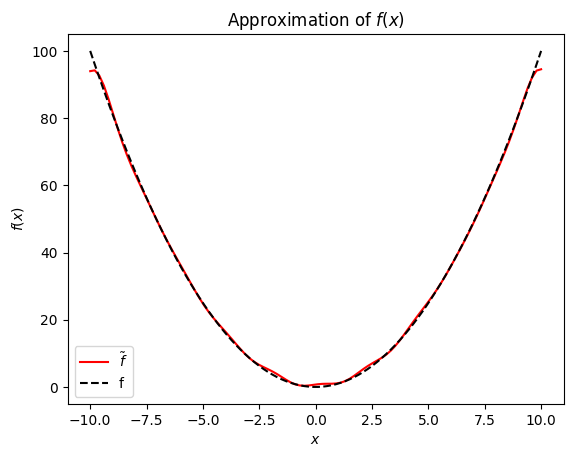

In [219]:
i = 2
f = locals()[f"f{i}"]
d = 100 # ds[i-1]
seed = None

# train to get weights
n_train = 100
rng = np.random.default_rng(None)
train_set = 20*rng.random(size=(n_train, n))-10
train_set = np.linspace(-10,10,n_train,endpoint=True)
train_set = np.atleast_2d(train_set).T
(A_train, b_train) = get_rbf_Ab(f, d, train_set, seed=10)

# TODO: What is difference between least squares and linear regression?
# ANS: The issue is where we take our points to perform linear regression on
model.fit(A_train, b_train)
# omega = model.named_steps['reg'].coef_
# omega = la.lstsq(A_train, b_train, rcond=None)[0]
omega = model.coef_

# evaluate the model
xs = np.linspace(-10, 10, n_train, endpoint=True)
eval_set = np.diag(xs) @ np.ones((len(xs), n))
(A_eval, b_eval) = get_rbf_Ab(f, d, eval_set, seed=10)

print(la.norm(A_train-A_eval, ord='fro'))

# plot
ax = plt.subplot()
# ax.plot(xs, A_eval@omega, label=r"$\tilde{f}$", linestyle="solid", color="red")
ax.plot(xs, model.predict(A_eval), label=r"$\tilde{f}$", linestyle="solid", color="red")
ax.plot(xs, b_eval, label="f", linestyle="dashed", color="black")
ax.set(
    title=r"Approximation of $f(x)$", 
    xlabel=r"$x$", 
    ylabel=r"$f(x)$"
)
ax.legend()

What did I learn:
- For random Fourier feature, we must use the same (random) affine transformation.

Questions:
- Learning seems quite sensitive to where I "train" my data (the interpolation is better for equally spaced points rather than random. Is this *always* the case?
- When I increase my dimension (see above), the shape is correct but the approximation seems off by a constant. Why does this happen when I increase the dimension?

Comparing the two datasets (i.e., ours vs sklearn), we have approximately similar training and testing errors.

**EDIT**: Removed since we changed how to generate (A,b).

### Training with SGD
In both the monomial and random kitchen sink, we used a least squares estimator (via `LinearRegression`) to fit the data. We can also consider stochastic gradient descent, or SGD for short. Let us consider that now, starting again with monomial basis and RBF with random Fourier features. We will use [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor).

In [ ]:
ds = 100 * np.ones(5, dtype=int)
n_train = 40
n_test = 20
model = Pipeline([
    ("scalar", StandardScaler()),
    ("reg", SGDRegressor(max_iter=1000, tol=1e-3, learning_rate="optimal", eta0=1e-1))
])
test(n, ds, n_train, n_test, get_polynomial_Ab, model)

**It seems polynomial does not play with with SGD. Likely due to the high condition number.**

Let us now consider RBF. We consider scaling and no scaling.

In [ ]:
ds = 100 * np.ones(5, dtype=int)
n_train = 40
n_test = 20
model = Pipeline([
    ("reg", SGDRegressor(max_iter=1000, tol=1e-3))
])
test(n, ds, n_train, n_test, get_rbf_Ab, model)

In [ ]:
ds = 100 * np.ones(5, dtype=int)
n_train = 40
n_test = 20
model = Pipeline([
    ("scalar", StandardScaler()),
    ("reg", SGDRegressor(max_iter=1000, tol=1e-3))
])
# model = SGDRegressor(max_iter=1000, tol=1e-3)
test(n, ds, n_train, n_test, get_rbf_Ab, model)

Let's play around with the learning rate.

In [ ]:
ds = 100 * np.ones(5, dtype=int)
n_train = 40
n_test = 20
model = Pipeline([
    ("scalar", StandardScaler()),
    ("reg", SGDRegressor(
        max_iter=1000, 
        tol=1e-3, 
        learning_rate="constant", 
        eta0=1e-2
    ))
])
test(n, ds, n_train, n_test, get_rbf_Ab, model)

## Tiling Coding (Course Coding)

Tiling coding is a type of course coding, where binary features are activitated (either 0 or 1) depending on whether the point is within a certain tile.

Mathematically, for every $i$, there exists a unique $x_i \in X$ such that
$$\begin{aligned} v_i(x) = \begin{cases} 1 & : x \in \mathrm{tile}(x_i) \\ 0 & : \text{o.w.} \end{cases} \end{aligned}.$$
$$
Here, each $v_i$ decomposes the domain $X$ into (equal length) tiles, or hypercubes. We assume the decomposition of $X$ for $v_i$ and $v_j$ shifted by a constant that is a fraction of the tile width along all dimension (to prevent overlap in any dimension).

Such a feature mapping can be useful where there are geographically based features. For example, if to capture a function that gets larger as one gets closer to an origin, we define features that take on values of 1 only close to the center.

**I will not code this since the next feature is a smoothed/continuous version of tiling coding**.

## Brief Tour: What is Reproducing Kernel Hilbert Space?

Recall that we want to approximate a function $f : X \mapsto \mathbb{R}$ via
$$
f(x) \approx v(x)^T\omega
$$
for some $\omega \in \mathbb{R}^d$. For example, in linear SVM, we let $v = I$ and define the classifier as
$$
\mathrm{sign}(\omega^Tx - b).
$$
However, many data sets may not be linearly separable (i.e., separated by a hyperplane), so we need a nonlinear seperation. We want to lift $x \mapsto \varphi(x)$, where $\varphi : X \mapsto H \subseteq \mathbb{R}^d$ for some $d > n$, where $H$ is a Hilbert space. Then we can compute instead
$$
\omega^Tx \to \langle \omega, \varphi(x) \rangle_H.
$$
Here, we abused notation and assume $\omega$ is defined according the respective space.
Often times, the larger the lifted space $d$ is (possibly infinite dimensional), the better approximation power we get.
So while this lifting procedure is appealing, it can be computationally intractble when $d$ is large.

The idea of Reproducing Kernel Hilbert Space (RKHS) is to use a kernel $k: H \times H \to \mathbb{R}$ and the *kernel trick* to avoid the need to explicitly compute $\varphi$. The kernel trick is a consequence of *Mercer's Theorem*, which says under suitable conditions for a lifting $\varphi$, there exists a kernel $k$ such that 
$$
k(x,x') = \langle \varphi(x), \varphi(x') \rangle_H, ~~ \forall x,x' \in X.
$$
This is a sufficient result, so it holds both ways. The key insight here is if we can find $k$, we do not need to form $\varphi$, which can be very high-dimensional.

Let us now apply this kernel trick to function approximation. Suppose we already have some data $\{(x_i,y_i=f(x_i))\}$, and we want to approximate $f$. Let us we write our weights in Hilbert space (i.e., $y_i \cdot \varphi(x_i)$ is the basis -- **WHY??**)
$$
\omega = \sum\limits_{i} \alpha_i y_i \varphi(x_i).
$$
Using the kernel trick,
$$
\langle \omega, \varphi(x) \rangle_H  = \sum\limits_i \alpha_i y_i \underbrace{\langle \varphi(x_i), \varphi(x) \rangle_H}_{k(x_i,x)}.
$$

## Radial Basis Function

We define the basis
$$
v_i(x) = k(x,c^{(i)}) := \mathrm{exp}\Big( \frac{\|x-c^{(i)}\|^2}{2\sigma_i^2} \Big).
$$

Notice that $v_i(x) \in (0,1]$, hence this is a relaxed version of a binary feature. 